In [335]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

#from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

import re

from wordcloud import WordCloud
import shap

## Load data

In [147]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_tokens.csv', sep=';')

df = df[~df['tokens_str'].isna()]

df['tokens'] = df['tokens_str'].progress_apply(
    lambda x: x.split(' ') 
#            .replace('ą', 'ą')
#            .replace('ć', 'ć')
#            .replace('ę', 'ę')
#            .replace('ń', 'ń')
#            .replace('ó', 'ó')
#            .replace('ś', 'ś')
#            .replace('ź', 'ź')
#            .replace('ż', 'ż')
)

100%|███████████████████████████████████| 7785/7785 [00:00<00:00, 215236.42it/s]


In [148]:
df = df[ df['assestment'] != 'brak' ]

Na potrzeby Twojej pracy, wypowiedzi z oceną brak można odrzucić, zbity_zegar interpretować jako fałsz. Resztę danych w zależności od przyjętego modelu, jeśli ocena jest binarna to prawde i blisko_prawdy mozna polaczyc razem, tak samo jak raczej_falsz i falsz. Jeśli jednak ocena jest przedziałem to można pokusić się o przyjęcie wartości 1, 0.75, 0.5, 0.25, 0 zakładając ze 1 to prawda a 0 to pełny fałsz.
sub_title_text_after to komentarz do wypowiedzi, moze pomóc rozwiać wątpliwości co do tego jak oceniane są wartości połówkowe i bliskie pełnych

In [149]:
df['assestment'].value_counts()

Prawda               2831
falsz                1308
Fałsz                1135
zbity_zegar           707
Manipulacja           705
raczej_falsz          288
polprawda             254
Nieweryfikowalne      236
prawda                179
blisko_prawdy          93
Częściowy fałsz       9
Name: assestment, dtype: int64

In [150]:
df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

In [151]:
df['assestment'].value_counts()

Fałsz               3438
Prawda              3103
Manipulacja          968
Nieweryfikowalne     236
Name: assestment, dtype: int64

In [152]:
df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

In [153]:
df = df.reset_index(drop=True)

In [154]:
df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   assestment     6541 non-null   int64  
 1   author         6511 non-null   object 
 2   text_clean     6541 non-null   object 
 3   sentiment_all  6541 non-null   float64
 4   sentiment_avg  6541 non-null   float64
 5   uniq_words     6541 non-null   float64
 6   uniq_lemm      6541 non-null   float64
 7   err            6541 non-null   float64
 8   net            6541 non-null   float64
 9   ADJ            6541 non-null   float64
 10  ADV            6541 non-null   float64
 11  NOUN           6541 non-null   float64
 12  tokens_str     6541 non-null   object 
 13  tokens         6541 non-null   object 
dtypes: float64(9), int64(1), object(4)
memory usage: 715.5+ KB


In [156]:
id_train, id_test = train_test_split(
    df.index.values.tolist(), 
    test_size=0.33, 
    stratify = df['assestment'].values,
    random_state=0)

y_train = df.loc[id_train,:].copy()['assestment']

y_test = df.loc[id_test,:].copy()['assestment']

## One-hot embeddings

In [285]:
df_one = df.copy()

df_one = df_one[['tokens']].reset_index().explode('tokens')
df_one['n'] = 1
df_one['tokens'] = df_one['tokens'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

In [286]:
df_one_trn = df_one.loc[id_train,:].copy()
df_one_tst = df_one.loc[id_test,:].copy()

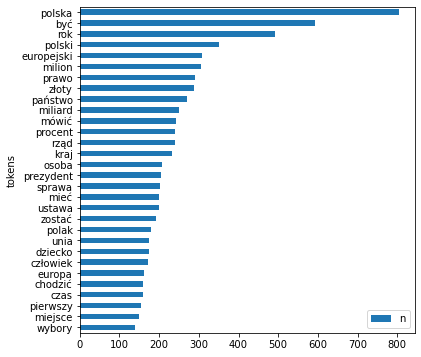

In [287]:
df_one_trn = df_one_trn[df_one_trn['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,6));
df_one_trn.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.show()

In [288]:
df_one_trn.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).index

Index(['wybory', 'miejsce', 'pierwszy', 'czas', 'chodzić', 'europa',
       'człowiek', 'dziecko', 'unia', 'polak', 'zostać', 'ustawa', 'mieć',
       'sprawa', 'prezydent', 'osoba', 'kraj', 'rząd', 'procent', 'mówić',
       'miliard', 'państwo', 'złoty', 'prawo', 'milion', 'europejski',
       'polski', 'rok', 'być', 'polska'],
      dtype='object', name='tokens')

In [289]:
df_one_trn_p = df_one_trn.drop_duplicates().pivot(index='index', columns='tokens', values='n').fillna(0)
df_one_trn_p.shape

(4382, 10107)

In [290]:
df_one_trn_p = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 1)]
df_one_trn_p.shape

(4382, 4558)

In [291]:
df_one_trn_p.columns.values

array(['abonament', 'aborcja', 'aborcyjny', ..., 'żądać', 'żłobek',
       'żłobk'], dtype=object)

In [292]:
df_one_tst_p = pd.merge(
    df_one_tst,
    pd.DataFrame({'tokens': df_one_trn_p.columns.values}),
    on='tokens',
    how='outer'
)
df_one_tst_p = df_one_tst_p.drop_duplicates().pivot(index='index', columns='tokens', values='n').fillna(0)
df_one_tst_p = df_one_tst_p[df_one_trn_p.columns.values]

In [293]:
df_one_trn_p.shape

(4382, 4558)

In [294]:
df_one_tst_p.shape

(2160, 4558)

In [295]:
df_one_tst_p = df_one_tst_p[df_one_tst_p.index.notna()]
df_one_tst_p.shape

(2159, 4558)

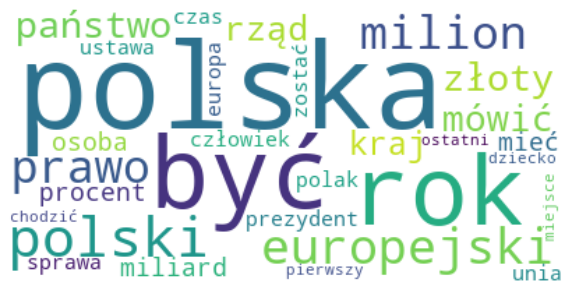

In [296]:
wordcloud = WordCloud(background_color='white',
                      max_words=30).generate_from_frequencies(df_one_trn_p.sum())

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [297]:
df_one_trn_p.shape

(4382, 4558)

In [298]:
def get_tfidf(df):
    tf = df.divide(df.sum(1).values, axis=0)
    idf = np.log10( (df.shape[0]+1)/(df.sum()+1) )
    tfidf = tf*idf
    tfidf_kindof = np.log10(df.sum()) * idf
    
    return tfidf, tfidf_kindof.sort_values(ascending=False)

In [299]:
tfidf_fn, tfidf_ko_fk =  get_tfidf(df_one_trn_p[y_train.sort_index()==0])
tfidf_t, tfidf_ko_t =  get_tfidf(df_one_trn_p[y_train.sort_index()==1])

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


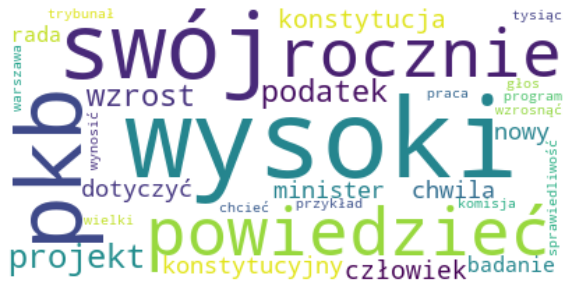

In [300]:
wordcloud = WordCloud(background_color='white',
                      max_words=30).generate_from_frequencies(tfidf_ko_t)

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

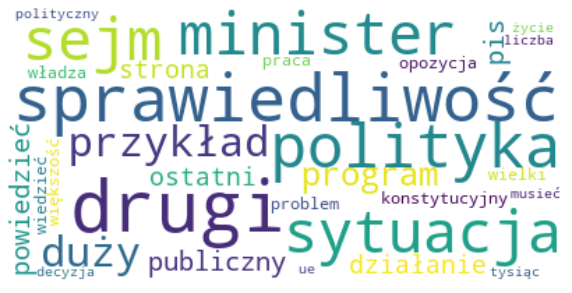

In [301]:
wordcloud = WordCloud(background_color='white',
                      max_words=30).generate_from_frequencies(tfidf_ko_fk)

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [336]:
logisticRegr = LogisticRegression()

In [337]:
X_train = df_one_trn_p.sort_index().values

X_test = df_one_tst_p.sort_index().values

In [338]:
logisticRegr.fit(X_train, y_train.sort_index().values)

LogisticRegression()

In [339]:
train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2303
           1       0.90      0.92      0.91      2079

    accuracy                           0.92      4382
   macro avg       0.92      0.92      0.92      4382
weighted avg       0.92      0.92      0.92      4382



In [340]:
test_predictions = logisticRegr.predict(X_test)

print(
    classification_report(
        y_test.sort_index().values, 
        test_predictions
    )
)

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1135
           1       0.62      0.60      0.61      1024

    accuracy                           0.64      2159
   macro avg       0.63      0.63      0.63      2159
weighted avg       0.64      0.64      0.64      2159



In [341]:
importance = logisticRegr.coef_[0]
importance.shape

(4558,)

In [342]:
df_logreg_imp = pd.DataFrame(
    {
        'token' : df_one_trn_p.columns.values.tolist(),
        'coef': importance,
        'coef_abs': np.abs(importance)
    }
)

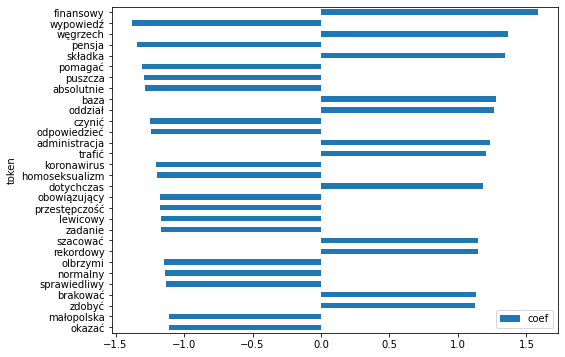

In [343]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp.sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

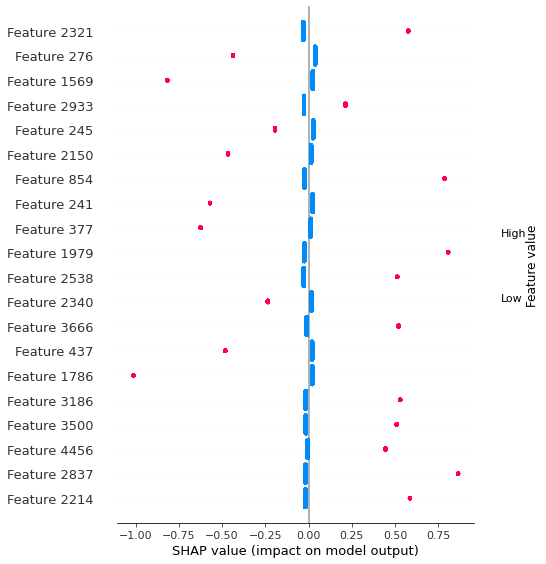

In [351]:
masker = shap.maskers.Independent(data = X_train)
explainer = explainer = shap.LinearExplainer(logisticRegr, masker)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

### XGBoost

In [352]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='multi:softmax' if False else 'binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train , y_train.sort_index().values)

train_predictions = xgbc0.predict(X_train)
test_predictions = xgbc0.predict(X_test)

In [353]:
print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2303
           1       0.76      0.77      0.77      2079

    accuracy                           0.78      4382
   macro avg       0.77      0.78      0.78      4382
weighted avg       0.78      0.78      0.78      4382



In [354]:
print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1135
           1       0.62      0.62      0.62      1024

    accuracy                           0.64      2159
   macro avg       0.64      0.64      0.64      2159
weighted avg       0.64      0.64      0.64      2159



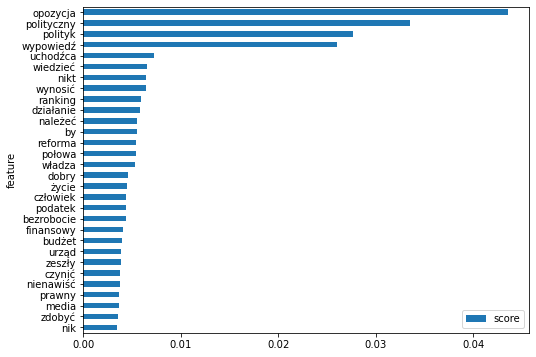

In [359]:
#plotting feature importance
features_list = df_one_trn_p.columns.values.tolist()

f, ax = plt.subplots(figsize=(8,6));
df_plot = pd.DataFrame({
    'feature' : features_list,
    'score' : xgbc0.feature_importances_
}).set_index('feature')
df_plot.sort_values('score').tail(30).plot(kind='barh', ax=ax)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


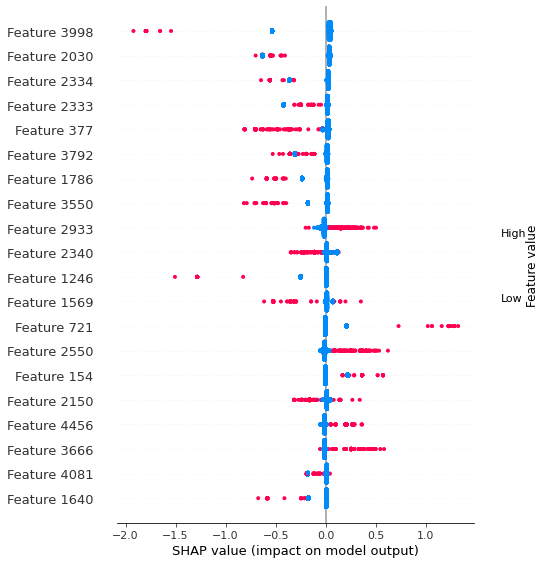

In [356]:
explainer = shap.TreeExplainer(xgbc0)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

### PCA

In [313]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

principalComponents = pca.fit_transform(X_train)

pca.explained_variance_ratio_.cumsum()

array([0.01412715, 0.02455178, 0.03404955, 0.04236893, 0.0503178 ,
       0.05756477, 0.06388351, 0.069315  , 0.07470794, 0.07988032])

### UMAP

In [314]:
import umap

trans = umap.UMAP(
    n_neighbors=5, 
    n_components=10, 
    random_state=42).fit(X_train)

In [315]:
train_embedding = trans.embedding_
test_embedding = trans.transform(X_test)

In [321]:
logisticRegr = LogisticRegression()

logisticRegr.fit(train_embedding, y_train.sort_index().values)

train_predictions = logisticRegr.predict(train_embedding)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      2303
           1       0.61      0.60      0.61      2079

    accuracy                           0.63      4382
   macro avg       0.63      0.63      0.63      4382
weighted avg       0.63      0.63      0.63      4382



/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [322]:
test_predictions = logisticRegr.predict(test_embedding)

print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.54      0.86      0.66      1135
           1       0.56      0.20      0.29      1024

    accuracy                           0.54      2159
   macro avg       0.55      0.53      0.48      2159
weighted avg       0.55      0.54      0.49      2159



### TfIdf approach

In [256]:
logisticRegr = LogisticRegression()

# cols = df_logreg_imp.sort_values('coef_abs').tail(2000)['token'].values
tfidf, _ =  get_tfidf(df_one_trn_p)

X_train = tfidf.sort_index().values
X_test = tfidf.sort_index().values

logisticRegr.fit(X_train, y_train.sort_index().values)

train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2303
           1       0.83      0.76      0.79      2079

    accuracy                           0.81      4382
   macro avg       0.82      0.81      0.81      4382
weighted avg       0.81      0.81      0.81      4382



## Doc2vec embeddings

In [257]:
df_doc2vec = df.copy()

df_doc2vec['documents'] = [TaggedDocument(doc, [str(i)]) for i, doc in enumerate(df_doc2vec['tokens'].values)]

In [258]:
vec_size = 3

In [259]:
model_dbow = Doc2Vec(dm=0, vector_size=vec_size, negative=5, hs=0, min_count=2, sample = 0, workers=-1)
model_dbow.build_vocab([x for x in tqdm(df_doc2vec['documents'].values[id_train])])

for epoch in tqdm(range(30)):
    model_dbow.train(utils.shuffle([x for x in df_doc2vec['documents'].values[id_train]]), total_examples=len(id_train), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 181.31it/s]


In [260]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=vec_size, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(df_doc2vec['documents'].values[id_train])])

for epoch in tqdm(range(30)):
    model_dmm.train(utils.shuffle([x for x in df_doc2vec['documents'].values[id_train]]), total_examples=len(id_train), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|███████████████████████████████████████████| 30/30 [00:12<00:00,  2.48it/s]


In [261]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [262]:
embeddings = [
    new_model.infer_vector(d[0]).tolist() for d in df_doc2vec['documents'].values 
]

In [263]:
if False:
    vec_final_size = 5
    
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=vec_final_size, 
                            metric='cosine').fit_transform(embeddings)
    
    df_doc2vec[[ 'e'+str(i) for i in range(vec_final_size) ]] = umap_embeddings
else:
    vec_final_size = 2*vec_size
    df_doc2vec[[ 'e'+str(i) for i in range(vec_final_size) ]] = embeddings

In [264]:
df_doc2vec.columns

Index(['assestment', 'author', 'text_clean', 'sentiment_all', 'sentiment_avg',
       'uniq_words', 'uniq_lemm', 'err', 'net', 'ADJ', 'ADV', 'NOUN',
       'tokens_str', 'tokens', 'documents', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5'],
      dtype='object')

In [272]:
X_train = df_doc2vec.loc[id_train,
    ['sentiment_all', 'sentiment_avg','uniq_words', 'uniq_lemm', 'err', 'net', 
     'ADJ', 'ADV', 'NOUN'] #+ [ 'e'+str(i) for i in range(vec_final_size) ]
].copy().sort_index()

X_test = df_doc2vec.loc[id_test,
    ['sentiment_all', 'sentiment_avg','uniq_words', 'uniq_lemm', 'err', 'net', 
     'ADJ', 'ADV', 'NOUN'] #+ [ 'e'+str(i) for i in range(vec_final_size) ]
].copy().sort_index()

## XGBoost

In [273]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='multi:softmax' if False else 'binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train , y_train.sort_index().values)

train_predictions = xgbc0.predict(X_train)
test_predictions = xgbc0.predict(X_test)

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [274]:
print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2303
           1       0.90      0.94      0.92      2079

    accuracy                           0.92      4382
   macro avg       0.92      0.92      0.92      4382
weighted avg       0.92      0.92      0.92      4382



In [275]:
confusion_matrix(y_train.sort_index().values, train_predictions)

array([[2079,  224],
       [ 125, 1954]])

In [284]:
print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1135
           1       0.53      0.52      0.53      1024

    accuracy                           0.56      2159
   macro avg       0.55      0.55      0.55      2159
weighted avg       0.56      0.56      0.56      2159



In [283]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_trn_scaled = scaler.transform(X_train)

logisticRegr = LogisticRegression()

logisticRegr.fit(X_trn_scaled, y_train.sort_index().values)

train_predictions = logisticRegr.predict(X_trn_scaled)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.57      0.69      0.62      2303
           1       0.56      0.43      0.49      2079

    accuracy                           0.57      4382
   macro avg       0.56      0.56      0.56      4382
weighted avg       0.57      0.57      0.56      4382



In [277]:
confusion_matrix(y_test, test_predictions)

array([[604, 531],
       [560, 464]])

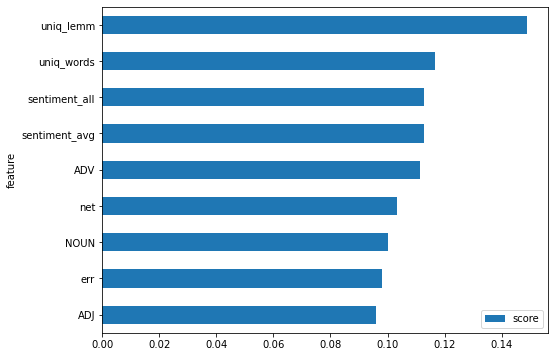

In [279]:
#plotting feature importance
features_list = [
    'sentiment_all', 'sentiment_avg','uniq_words', 'uniq_lemm', 'err', 'net', 
     'ADJ', 'ADV', 'NOUN'] #+ [ 'e'+str(i) for i in range(vec_final_size) ]

f, ax = plt.subplots(figsize=(8,6));
df_plot = pd.DataFrame({
    'feature' : features_list,
    'score' : xgbc0.feature_importances_
}).set_index('feature')
df_plot.sort_values('score').plot(kind='barh', ax=ax)
plt.show()